In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from collections import namedtuple
%pylab inline
pylab.rcParams['figure.figsize'] = (14,6)

/Users/illarion.khliestov/Projects/data_mining/.venv/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Populating the interactive namespace from numpy and matplotlib


First of all we should load our data. It was previously saved to .csv file from https://www.investing.com/currencies/usd-eur-historical-data and now can be read from disk.

In [2]:
# load data and get some information about it
base_file = 's_and_p_500_hist.csv'
df = pd.read_csv(base_file, index_col='Date')
print("Shape:", df.shape)
print("Columns:", df.columns)

Shape: (2516, 6)
Columns: Index(['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')


In [3]:
# Drop unecessary columns (preserve only Date and Price)
columns_to_drop = [c for c in df.columns if c not in ['Date', 'Price']]
df = df.drop(columns_to_drop, axis=1)
print("Columns:", df.columns)
df.head(5)

Columns: Index(['Price'], dtype='object')


,Price
Date,
"Dec 31, 2019","3,230.78"
"Dec 30, 2019","3,221.29"
"Dec 27, 2019","3,240.02"
"Dec 26, 2019","3,239.91"
"Dec 24, 2019","3,223.38"


In [4]:
# change Data order, so the oldest entries will be the first one
df = df.reindex(index=df.index[::-1])
# make sure prices are numeric
df['Price'] = pd.to_numeric(df['Price'].apply(lambda x: x.replace(',', '')))
# and convert date to datetime format
df.index = pd.to_datetime(df.index)
df.head(5)

,Price
Date,
2010-01-04,1132.99
2010-01-05,1136.52
2010-01-06,1137.14
2010-01-07,1141.69
2010-01-08,1144.98


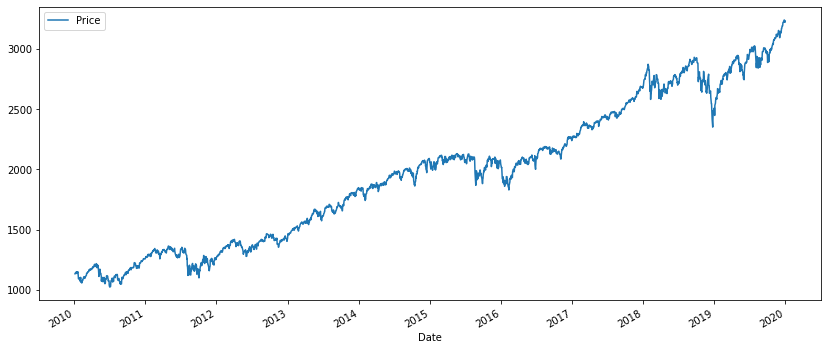

In [5]:
# diplay data
df.plot();

We may see that there is one large increasing trend and no any seasonality in data.

Now we can add missed entries(holidays) to dataframe

In [6]:
full_time_range = pd.date_range(start=df.index[0], end=df.index[-1])
df = df.reindex(index=full_time_range)
print("Before interpolation:")
print(df.head(10))
df = df.interpolate()
print("\nAfter interpolation:")
print(df.head(10))

Before interpolation:
              Price
2010-01-04  1132.99
2010-01-05  1136.52
2010-01-06  1137.14
2010-01-07  1141.69
2010-01-08  1144.98
2010-01-09      NaN
2010-01-10      NaN
2010-01-11  1146.98
2010-01-12  1136.22
2010-01-13  1145.68

After interpolation:
                  Price
2010-01-04  1132.990000
2010-01-05  1136.520000
2010-01-06  1137.140000
2010-01-07  1141.690000
2010-01-08  1144.980000
2010-01-09  1145.646667
2010-01-10  1146.313333
2010-01-11  1146.980000
2010-01-12  1136.220000
2010-01-13  1145.680000


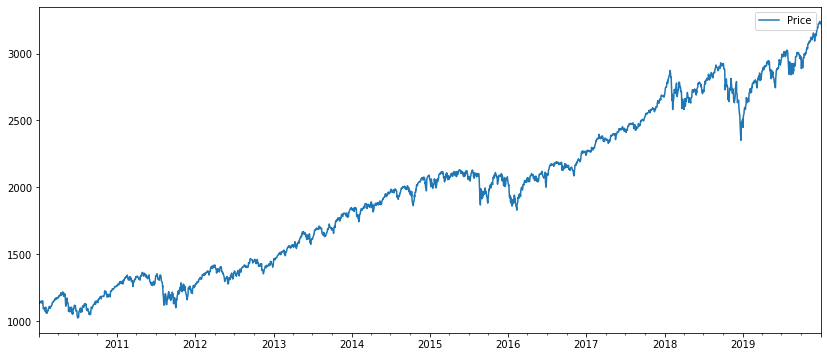

In [7]:
# plot interpolated data
df.plot();

In [8]:
# Helper functions for plot
def list_available_years(df):
    return sorted(list(set([idx.year for idx in df.index])))

def reindex_to_range(df):
    df.index = range(df.shape[0])
    return df

Let's see visualisation from yeach year separately

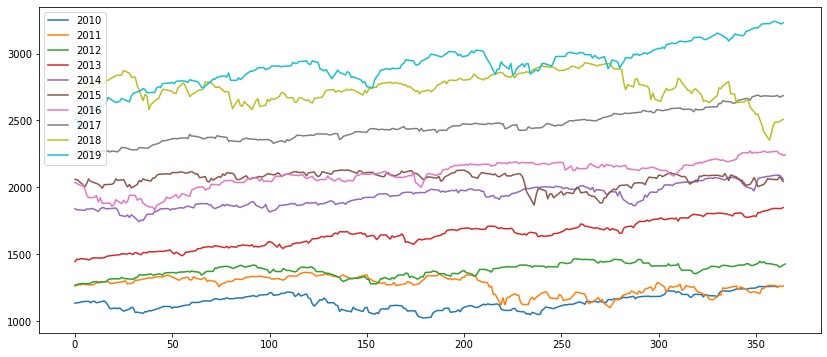

In [9]:
fig, ax = subplots()
for year in list_available_years(df):
    year_data = reindex_to_range(df[df.index.year == year]['Price'])
    ax.plot(year_data, label=str(year))
ax.legend();

Now let's define some help functions that may speedup our future research

In [10]:
# define error
def mase(predicted, expected, verbose=False):
    predicted, expected = np.array(predicted), np.array(expected)
    min_size = min(predicted.shape[0], expected.shape[0])
    predicted, expected = predicted[:min_size], expected[:min_size]
    numerator = np.mean(np.abs(predicted - expected))
    denom = np.mean(np.abs(expected[1:] - expected[:-1]))
    if verbose:
        print("Num:", numerator, "Den:", denom)
    return numerator / denom

# define help plot function
def visualise(predicted, expected, title):
    fig, ax = subplots()
    ax.plot(predicted)
    ax.plot(expected)
    ax.legend(["Predicted", "Ground Truth"])
    ax.set_title(title)
    
def calculate_error_and_show(pred, expected, text):
    error = mase(pred, expected)
    visualise(pred, expected, title=text + ', error: %.2f' % error)

Split data to train and test subsets, provide some parameters initialization

In [11]:
# predicted period for N days
prediction_period = 7
# split data to train and test
all_years = list_available_years(df)
# all years but last
year_idx = 1
train_years = all_years[:-year_idx]
train_data = np.array(df[df.index.year.isin(train_years)]['Price'])
print("train data size:", len(train_data))
# last year
test_year = all_years[-year_idx]
test_data = np.array(df[df.index.year == test_year]['Price'])
# for siplicity - let's crop our test data so it match our prediction period
test_data = test_data[:prediction_period * (len(test_data) // prediction_period)]
print("test data size:", len(test_data))

train data size: 3284
test data size: 364


And now we finally can start making our predictions. In general we're going to try two approaches:

- Naive approach - just copy previous data
- Linear trend extraction and high frequency predictions

We'll see what will give us better results

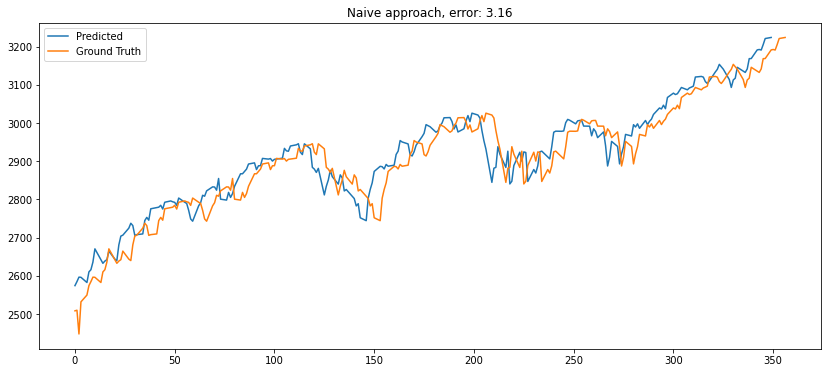

In [12]:
# define and try naive prediction method
def naive(train, expected, period=14):
    """Copy nearest previous data with some shift"""
    available_chunks = len(expected) // period
    expected = np.copy(expected)
#     predicted = np.copy(train[-available_chunks * period:])
    predicted = np.copy(expected[period: (available_chunks - 1) * period])
    expected = np.copy(expected[:period * (available_chunks - 1)])
    error = mase(predicted, expected)
    visualise(predicted, expected, title='Naive approach, error: %.2f' % error)
    return error

naive_error = naive(np.copy(train_data), np.copy(test_data), period=prediction_period)

In [13]:
# define non trivial approach

# some helper methods
def normalize(array):
    array = np.array(array)
    array_min = np.min(array)
    array = array - np.min(array)
    array_max = np.max(array)
    array = array / np.max(array)
    return array, array_min, array_max

def denormalize(array, min_, max_):
    array *= max_
    array += min_
    return array

def forecast(array, win_size, n_pred_points, reg_term, expected):
    array, array_min, array_max = normalize(array)
    # build model based on the previous years
    array_len = len(array)
    n_chunks = math.ceil(array_len / win_size)
    n_entries = n_chunks * win_size
    enlarged_array = np.zeros(n_entries) - 10
    enlarged_array[-len(array):] = array
    F = enlarged_array.reshape((win_size, n_chunks), order='F')
    # populate zero values with values from the next year
    zeros_mask = F[:, 0] == -10
    F[:, 0][zeros_mask] = F[:, 1][zeros_mask]

    F1 = F[:, :-1]
    F2 = F[:, 1:]
    A = (F2 @ F1.T) @ np.linalg.inv((F1 @ F1.T + reg_term * np.eye(F1.shape[0])))
    
    # make actual predictions
    predictions = []
    n_pred_chunks = n_pred_points // win_size
    norm_expected, expected_min, expected_max = normalize(expected)

    for chunk_idx in range(n_pred_chunks):
        chunk = norm_expected[chunk_idx * win_size: (chunk_idx + 1) * win_size]
        pred_chunk = A @ chunk
        predictions.extend(pred_chunk.reshape(-1))
    
    predictions, _, _ = normalize(np.array(predictions))
    predictions = denormalize(predictions, min_=expected_min, max_=expected_max)
    
    model_setup = np.concatenate((
        F[:, 0][:, None],
        (A @ F[:, :-1]
    )), axis=1)
    model_setup = model_setup.reshape(-1, order='F')
    # now we should drop dummy values added previously
    model_setup = model_setup[-array_len:]
    model_setup = denormalize(model_setup, min_=array_min, max_=array_max)
    return predictions, model_setup
    

# predict trend with linear model
trend_predictions, model_setup = forecast(
    np.copy(train_data),
    win_size=prediction_period,
    n_pred_points=len(test_data),
    reg_term=0.3,
    expected=test_data
)

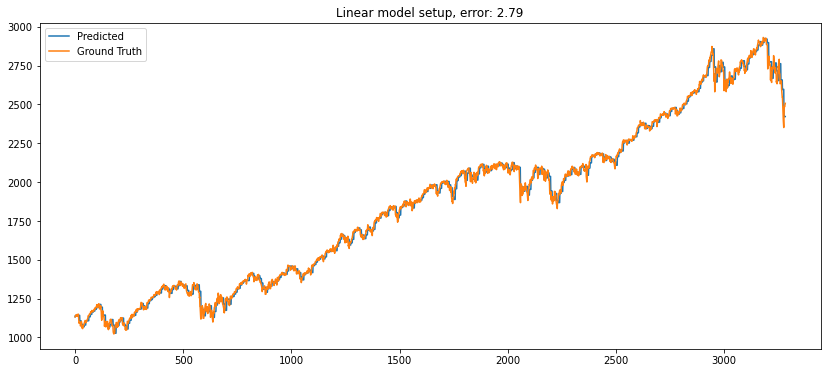

In [14]:
# visualize how well out linear model fit in general
calculate_error_and_show(model_setup, train_data, 'Linear model setup')

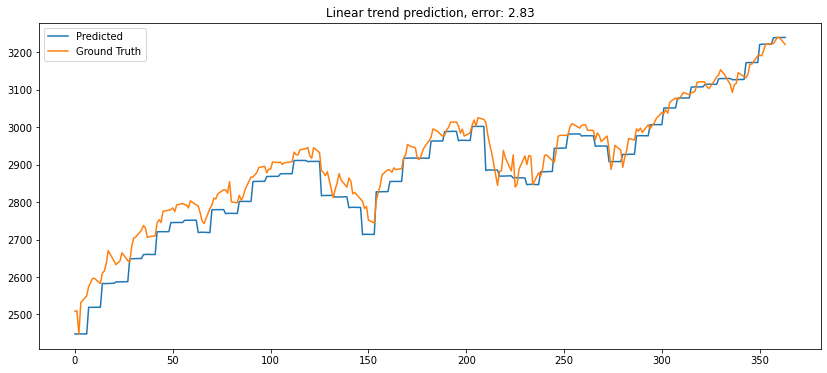

In [15]:
calculate_error_and_show(trend_predictions, test_data, 'Linear trend prediction')

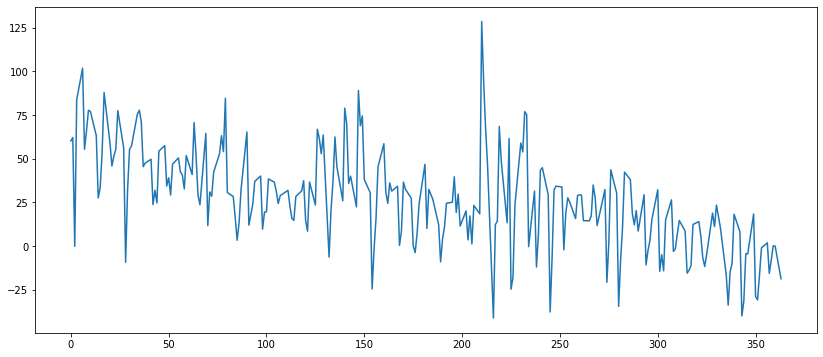

In [16]:
# extract trend from data
test_data_data_wo_trend = test_data - trend_predictions
pylab.plot(test_data_data_wo_trend);

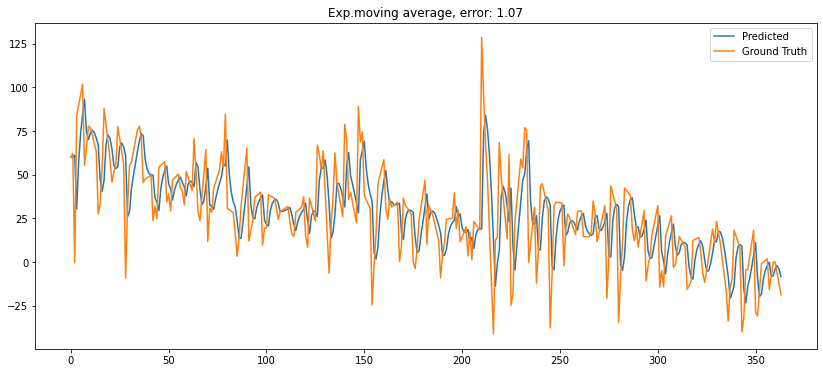

In [17]:
# define algorithm for frequency prediction
def exp_moving_average(expected, alpha):
    # just initialize with last existing data
    predictions = [expected[0]]
    for idx in range(1, len(expected)):
        prev_pred = predictions[-1]
        prev_real_data = expected[idx - 1]
        new_pred = alpha * prev_real_data + (1 - alpha) * prev_pred
        predictions.append(new_pred)
    return predictions

high_freq_pred = exp_moving_average(test_data_data_wo_trend, alpha=0.5)
calculate_error_and_show(high_freq_pred, test_data_data_wo_trend, 'Exp.moving average')

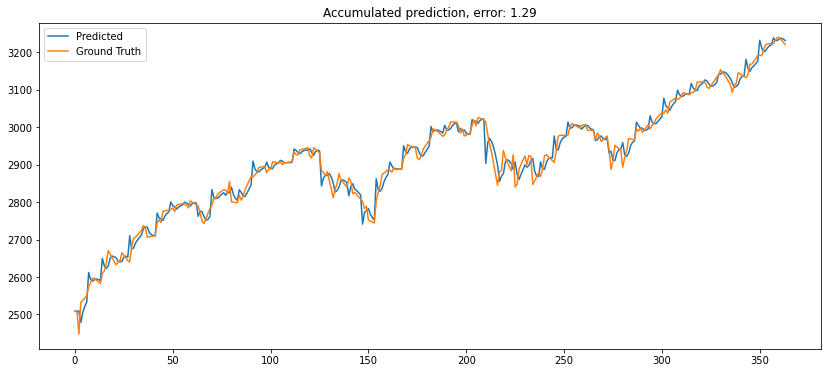

In [18]:
accumulated_pred = trend_predictions + high_freq_pred
calculate_error_and_show(accumulated_pred, test_data, 'Accumulated prediction')

In [19]:
# identify the best parameters for the proposed model
Entry = namedtuple('Entry', ['error', 'trend_reg_term', 'high_freq_alpha'])

errors_and_settings = []
for trend_reg_term in np.linspace(0.1, 0.9, 9):
    for high_freq_alpha in np.linspace(0.1, 0.9, 9):
        trend_predictions, model_setup = forecast(
            np.copy(train_data),
            win_size=prediction_period,
            n_pred_points=len(test_data),
            reg_term=trend_reg_term,
            expected=np.copy(test_data)
        )
        test_data_data_wo_trend = test_data - trend_predictions
        high_freq_pred = exp_moving_average(test_data_data_wo_trend, alpha=high_freq_alpha)
        accumulated_pred = trend_predictions + high_freq_pred
        error = mase(accumulated_pred, test_data)
        errors_and_settings.append(Entry(error, trend_reg_term, high_freq_alpha))
        
errors_and_settings = sorted(errors_and_settings, key=lambda x: x[0])
print("The best results and parameters for the proposed compound model are:")
print(errors_and_settings[0])

The best results and parameters for the proposed compound model are:
Entry(error=1.183453661265134, trend_reg_term=0.9, high_freq_alpha=0.9)


**Final thoughts**

As fas as you see we've got quite nice results compared with the naive approach. Naive: 2.79, Our model: 1.18. And this is quite a limit for the existing approach and provided data. As a future improvements we can consider more complex models.